In [4]:
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.transforms import transforms
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
from torchvision import models

from tensorboardX import SummaryWriter
writer = SummaryWriter()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. 데이터 불러오기

In [164]:
# MEAN = (0.485, 0.456, 0.406) # 해당 데이터는 정규화시 사용되는 평균값으로, 실제 데이터의 평규값을 구해야합니다.
# STD = (0.229, 0.224, 0.225)  # 해당 데이터는 정규화시 사용되는 표준편차값으로, 실제 데이터의 표준편차값 구해야합니다.

transforms_train = transforms.Compose([
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    transforms.Grayscale(num_output_channels=3),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    RandomHorizontalFlip(p=0.5),        # 과적합을 막기 위해 이미지를 랜덤으로 좌우 대칭을 변환합니다.
    transforms.RandomRotation(degrees=(-15, 15)),   # 과적합을 막기 위해 이미지를 무작위로 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # 과적합을 막기 위한 이미지의 밝기와 대비를 무작위로 변경
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),              # tensor 로 데이터 타입을 바꿉니다
    transforms.Resize((224, 224)),      # 이미지 사이즈를 변경합니다. (이는 사용 모델에 따라 변경 될 수 있음)
    transforms.Grayscale(num_output_channels=3),             # 이 이미지의 경우 흑백으로 처리하는 것이 좋습니다. 근데 RGB 채널이 있으므로 이 함수로 흑백으로 변환합니다.
    # transforms.Normalize(MEAN,STD)    # 흑백 이미지이므로 정규화는 생략
])

# ImageFolder 함수를 사용하여 이미지를 불러옵니다.
# train 폴더 내부에는 내가 분류하고 싶은 이미지별로 폴더 정리가 되어있어야 합니다
# 이 프로젝트에서는 [Normal, PNEUMONIA] 두개의 폴더로 분류가 되어있습니다.
# Normal 은 label 0번, PNEUMONIA 은 label 1번으로 라벨링됩니다.
# ImageFolder 함수는 이미지를 불러오는 동시에, 폴더 위치별로 정답 데이터가 라벨링 됩니다.
train_datasets = datasets.ImageFolder(root="data/train", transform=transforms_train)
test_datasets = datasets.ImageFolder(root="data/test", transform=transforms_test)
val_datasets = datasets.ImageFolder(root="data/val", transform=transforms_test) # 평가용 데이터 준비

## 데이터 확인해보기

### 학습 데이터 수 확인

In [165]:
len(train_datasets) 

5216

### 분류할 클래스 리스트 보기

In [166]:
train_datasets.classes

['NORMAL', 'PNEUMONIA']

### 이미지 그리기

In [167]:
import numpy as np

# def denormalize(image, mean, std):
#     mean = torch.tensor(mean).view(3, 1, 1)
#     std = torch.tensor(std).view(3, 1, 1)
#     return image * std + mean

def view_img(tensor_image, title="title", cmap=None):
    """
    PyTorch 텐서(Tensor)를 시각화하는 함수
    """
    # 텐서를 넘파이 배열로 변환
    img_data = tensor_image.numpy()

    # 이미지 차원 순서 변경
    # PyTorch: (채널, 높이, 너비) -> Matplotlib: (높이, 너비, 채널)
    plt.imshow(np.transpose(img_data, (1, 2, 0)), cmap=cmap)

    # 이미지에 제목을 설정하고 화면에 표시
    plt.title(title)
    plt.show()

### + 튜플 데이터 타입에 대해서

In [168]:
tu = ('김서영', 99)
item0 = tu[0]
item1 = tu[1]
print(item0, item1)

name, year = tu
print(name, year)

김서영 99
김서영 99


In [169]:
image, label = train_datasets[0]
print(image) # 이미지
print(label) # 0
print(train_datasets.classes[label]) # NORMAL

tensor([[[0.6570, 0.7250, 0.8138,  ..., 0.0498, 0.0609, 0.0628],
         [0.6374, 0.6889, 0.7818,  ..., 0.0534, 0.0599, 0.0649],
         [0.6289, 0.6549, 0.7279,  ..., 0.0558, 0.0604, 0.0659],
         ...,
         [0.0521, 0.0467, 0.0413,  ..., 0.0825, 0.0829, 0.0828],
         [0.0546, 0.0464, 0.0411,  ..., 0.0857, 0.0827, 0.0824],
         [0.0560, 0.0474, 0.0413,  ..., 0.0922, 0.0892, 0.0825]],

        [[0.6570, 0.7250, 0.8138,  ..., 0.0498, 0.0609, 0.0628],
         [0.6374, 0.6889, 0.7818,  ..., 0.0534, 0.0599, 0.0649],
         [0.6289, 0.6549, 0.7279,  ..., 0.0558, 0.0604, 0.0659],
         ...,
         [0.0521, 0.0467, 0.0413,  ..., 0.0825, 0.0829, 0.0828],
         [0.0546, 0.0464, 0.0411,  ..., 0.0857, 0.0827, 0.0824],
         [0.0560, 0.0474, 0.0413,  ..., 0.0922, 0.0892, 0.0825]],

        [[0.6570, 0.7250, 0.8138,  ..., 0.0498, 0.0609, 0.0628],
         [0.6374, 0.6889, 0.7818,  ..., 0.0534, 0.0599, 0.0649],
         [0.6289, 0.6549, 0.7279,  ..., 0.0558, 0.0604, 0.

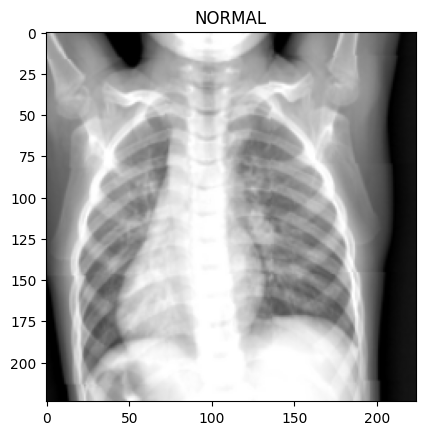

In [170]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

In [171]:
image, label = train_datasets[5000]
print(image) # 이미지
print(label) # 1
print(train_datasets.classes[label]) # PNEUMONIA

tensor([[[0.0354, 0.0385, 0.0383,  ..., 0.0048, 0.0048, 0.0048],
         [0.0356, 0.0385, 0.0381,  ..., 0.0048, 0.0048, 0.0048],
         [0.0354, 0.0384, 0.0382,  ..., 0.0048, 0.0048, 0.0048],
         ...,
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048]],

        [[0.0354, 0.0385, 0.0383,  ..., 0.0048, 0.0048, 0.0048],
         [0.0356, 0.0385, 0.0381,  ..., 0.0048, 0.0048, 0.0048],
         [0.0354, 0.0384, 0.0382,  ..., 0.0048, 0.0048, 0.0048],
         ...,
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048]],

        [[0.0354, 0.0385, 0.0383,  ..., 0.0048, 0.0048, 0.0048],
         [0.0356, 0.0385, 0.0381,  ..., 0.0048, 0.0048, 0.0048],
         [0.0354, 0.0384, 0.0382,  ..., 0.0048, 0.0048, 0.

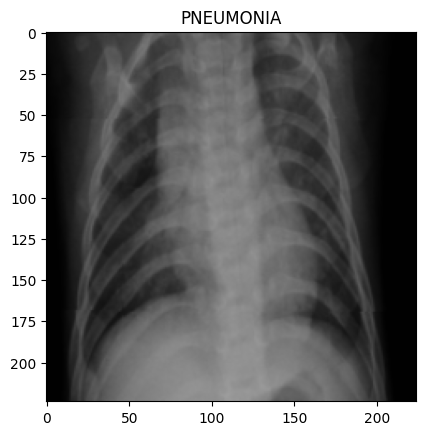

In [172]:
view_img(image, title=train_datasets.classes[label], cmap='gray')

# 2. 데이터 배치사이즈로 분리하기

In [173]:
# DataLoader 를 사용하여 데이터를 나눈다
# batch_size 몇 개씩 그룹 지을지 정한다
# shuffle 데이터를 순서대로 나누는 것이 아니라 랜덤으로 섞어서 자른다 
# ⭐⭐ 학습에 영향을 줄 수 있으므로 Train Data 에는 True 로 설정 하자!
train_dataLoader = DataLoader(train_datasets, batch_size=32, shuffle=True) 
test_dataLoader = DataLoader(test_datasets, batch_size=32)
val_dataLoader = DataLoader(val_datasets, batch_size=32) # 평가용 데이터 준비

## 데이터 확인하기

tensor([[[0.0373, 0.0373, 0.0373,  ..., 0.3637, 0.3578, 0.0373],
         [0.0378, 0.0376, 0.0374,  ..., 0.3760, 0.3672, 0.0373],
         [0.0496, 0.0455, 0.0419,  ..., 0.3898, 0.3767, 0.0373],
         ...,
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373]],

        [[0.0373, 0.0373, 0.0373,  ..., 0.3637, 0.3578, 0.0373],
         [0.0378, 0.0376, 0.0374,  ..., 0.3760, 0.3672, 0.0373],
         [0.0496, 0.0455, 0.0419,  ..., 0.3898, 0.3767, 0.0373],
         ...,
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
         [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373]],

        [[0.0373, 0.0373, 0.0373,  ..., 0.3637, 0.3578, 0.0373],
         [0.0378, 0.0376, 0.0374,  ..., 0.3760, 0.3672, 0.0373],
         [0.0496, 0.0455, 0.0419,  ..., 0.3898, 0.3767, 0.

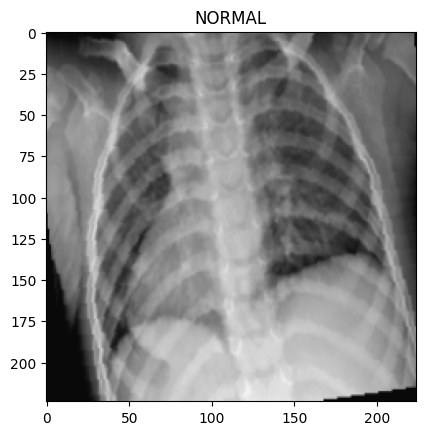

In [174]:
images, labels = next(iter(train_dataLoader)) # 튜플 (배치사이즈 만큼의 이미지들, 배치사이즈 만큼의 정답들)
print(images[0])
print(labels[0])

view_img(images[0], train_datasets.classes[labels[0]], cmap='gray')

## 데이터 형태 확인하기

In [175]:
# 차원 수 확인하기
images.dim()

4

In [176]:
# 배치사이즈 수만큼 분리된 데이터의 형태 확인하기
# 각 차원의 의미: [배치사이즈, 채널수, 이미지 가로 사이즈, 이미지 세로 사이즈]
images.shape

torch.Size([32, 3, 224, 224])

In [177]:
# 이미지 한장의 데이터 형태 확인하기
images[0].shape

torch.Size([3, 224, 224])

## 이미지 그리드로 확인하기

In [178]:
def view_grid_img(images, title):
    images_data = torchvision.utils.make_grid([image for image in images])

    print(labels)
    view_img(images_data, title)

tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1])


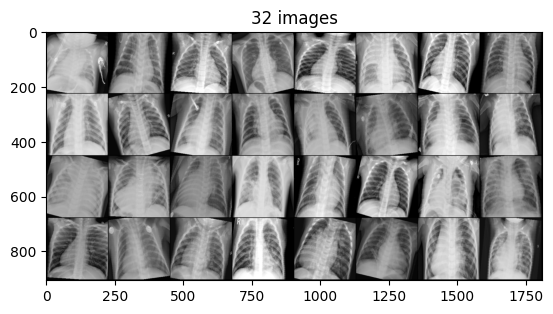

In [179]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataLoader)) # 튜플 (한개의 배치에 들어있는 이미지들, 한개의 배치에 들어있는 정답들)
images_data = torchvision.utils.make_grid(images) # 이미지를 그리드로 만든다

print(labels)
view_img(images_data, '32 images')

# 3. 모델 정의하기/준비하기

## 1) 모델 가져오기

In [180]:
# pretrained 는 deprecated 됨
# pretrained 라는 옵션, 파라미터가 더 이상 사용되지 않는다.
# 이는 곳 없어질수도 있는 위험한 파라미터값이다. > 이후에 이부분이 사라질 가능성 있음!
model = models.efficientnet_b0(pretrained = True)
model

c:\Potenup\DeepLearning-Pneumonia\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [181]:
from torchvision.models import ResNet34_Weights, EfficientNet_B0_Weights

# y = w1x1 + w2x2 + .... + B
# w1, w2 와 같은 회기계수, 가중치, 파라미터 값을 세부조정할 수 있도록 변경 됨

# pretrained = True 로 설정한 것과 동일하게 작동하는 코드
model = models.efficientnet_b0(weights = EfficientNet_B0_Weights.DEFAULT)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 2) 파인 튜닝하기

### 동결하기

In [182]:
for param in model.parameters():
    param.requires_grad = False

### 분류기 수정하기

In [183]:
# Renet34
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)

In [184]:
# EfficientNet_B0
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=1000, bias=True)
  )

# 4. 모델 학습하기

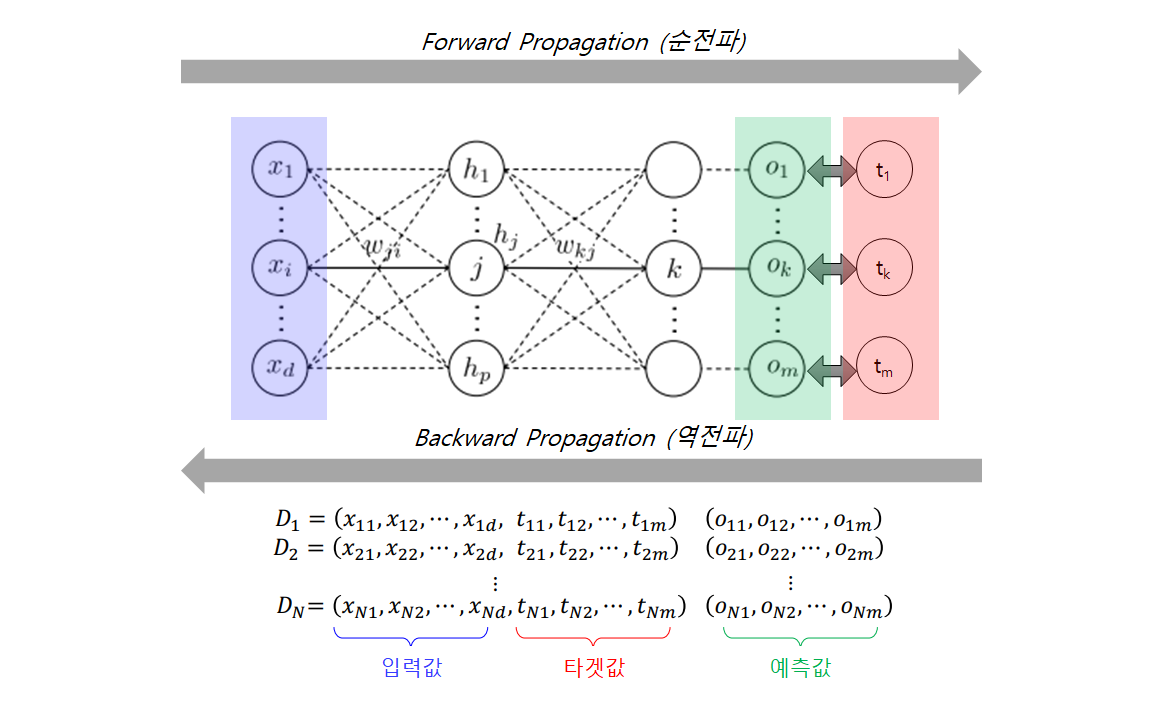

In [196]:
# 모델 학습 큰 흐름
# 1) 순전파
# 2) 손실함수
# 3) 역전파, 파라미터 업데이터

# 모델을 gpu에 넣는다
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optim = Adam(model.parameters(), lr=1e-3) # 최적화 함수 0.001 ~ 0.003
criterion = nn.CrossEntropyLoss()         # 손실함수
epochs = 90

from tensorboardX import SummaryWriter
# 텐서보드 활용하여, 최적화 과정을 시각화 합니다
writer = SummaryWriter()
step = 0

for epoch in range(epochs):
    for images, labels in tqdm.tqdm(train_dataLoader): # (배치사이즈 만큼의 이미지 , 배치사이즈 만큼의 라벨)
        optim.zero_grad() # 📌 최적화 함수를 초기화 해야함 (한 번 학습시 마다)
        
        # 1) 순전파
        preds = model(images.to(device))
        
        # 2) 손실계산
        loss = criterion(preds, labels.to(device))

        # 3) 역전파
        loss.backward()
        optim.step()

        step += 1 # step = step + 1

    print(f"{epoch + 1} loss : {loss}")

100%|██████████| 163/163 [01:51<00:00,  1.46it/s]


1 loss : 0.11743654310703278


100%|██████████| 163/163 [01:46<00:00,  1.53it/s]


2 loss : 0.2508658468723297


100%|██████████| 163/163 [01:46<00:00,  1.52it/s]


3 loss : 0.021139662712812424


100%|██████████| 163/163 [01:47<00:00,  1.52it/s]


4 loss : 0.11468292027711868


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


5 loss : 0.1432289183139801


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


6 loss : 0.10209421813488007


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


7 loss : 0.12553666532039642


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


8 loss : 0.2735424339771271


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


9 loss : 0.09849358350038528


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


10 loss : 0.015258844941854477


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


11 loss : 0.14427633583545685


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


12 loss : 0.06151322275400162


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


13 loss : 0.07876542210578918


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


14 loss : 0.19355952739715576


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


15 loss : 0.09899871796369553


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


16 loss : 0.11331980675458908


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


17 loss : 0.4177286624908447


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


18 loss : 0.043127864599227905


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


19 loss : 0.21082046627998352


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


20 loss : 0.053442150354385376


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


21 loss : 0.059843871742486954


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


22 loss : 0.13788573443889618


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


23 loss : 0.059474483132362366


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


24 loss : 0.04473792016506195


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


25 loss : 0.03728756308555603


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


26 loss : 0.2514338195323944


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


27 loss : 0.06359788030385971


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


28 loss : 0.08179949969053268


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


29 loss : 0.04241714999079704


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


30 loss : 0.08960267901420593


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


31 loss : 0.048954129219055176


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


32 loss : 0.08048363775014877


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


33 loss : 0.22708135843276978


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


34 loss : 0.15484356880187988


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


35 loss : 0.0951399952173233


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


36 loss : 0.2290814369916916


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


37 loss : 0.046356555074453354


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


38 loss : 0.14890989661216736


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


39 loss : 0.10007448494434357


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


40 loss : 0.042744074016809464


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


41 loss : 0.13656127452850342


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


42 loss : 0.11347499489784241


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


43 loss : 0.1565539538860321


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


44 loss : 0.07069386541843414


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


45 loss : 0.25046226382255554


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


46 loss : 0.3530505895614624


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


47 loss : 0.13308881223201752


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


48 loss : 0.061569105833768845


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


49 loss : 0.053560636937618256


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


50 loss : 0.09095839411020279


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


51 loss : 0.1955648958683014


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


52 loss : 0.0307247806340456


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


53 loss : 0.32605692744255066


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


54 loss : 0.2075575590133667


100%|██████████| 163/163 [01:49<00:00,  1.48it/s]


55 loss : 0.2262122929096222


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


56 loss : 0.24853000044822693


100%|██████████| 163/163 [01:50<00:00,  1.47it/s]


57 loss : 0.07011909037828445


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


58 loss : 0.047438330948352814


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


59 loss : 0.07340637594461441


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


60 loss : 0.050216998904943466


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


61 loss : 0.21534425020217896


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


62 loss : 0.11409573256969452


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


63 loss : 0.11853261291980743


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


64 loss : 0.06338589638471603


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


65 loss : 0.06865085661411285


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


66 loss : 0.0818362608551979


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


67 loss : 0.12804868817329407


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


68 loss : 0.5086345672607422


100%|██████████| 163/163 [01:49<00:00,  1.48it/s]


69 loss : 0.12229108810424805


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


70 loss : 0.04083159193396568


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


71 loss : 0.11867021769285202


100%|██████████| 163/163 [01:49<00:00,  1.50it/s]


72 loss : 0.004461456090211868


100%|██████████| 163/163 [01:49<00:00,  1.48it/s]


73 loss : 0.09636148065328598


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


74 loss : 0.04063833877444267


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


75 loss : 0.039330605417490005


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


76 loss : 0.024114049971103668


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


77 loss : 0.14408835768699646


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


78 loss : 0.05994086340069771


100%|██████████| 163/163 [01:49<00:00,  1.48it/s]


79 loss : 0.0970744863152504


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


80 loss : 0.024737205356359482


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


81 loss : 0.042562637478113174


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


82 loss : 0.24905402958393097


100%|██████████| 163/163 [01:48<00:00,  1.51it/s]


83 loss : 0.14986640214920044


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


84 loss : 0.08974821865558624


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


85 loss : 0.09209927171468735


100%|██████████| 163/163 [01:49<00:00,  1.48it/s]


86 loss : 0.0692850723862648


100%|██████████| 163/163 [01:49<00:00,  1.48it/s]


87 loss : 0.02502204105257988


100%|██████████| 163/163 [01:49<00:00,  1.49it/s]


88 loss : 0.13238903880119324


100%|██████████| 163/163 [01:48<00:00,  1.50it/s]


89 loss : 0.1606305092573166


100%|██████████| 163/163 [01:47<00:00,  1.51it/s]

90 loss : 0.03121441975235939


💡 가중치 초기화(Weight Initialization)를 해야하는 이유
모델의 층이 깊어질수록,   
활성화 함수 이후 데이터의 분포가 한쪽으로 쏠릴 수 있다.   
이러한 현상은 효율적이고 원활한 모델 학습을 방해한다.

# 5. 모델 저장하기

In [197]:
torch.save(model.state_dict(), 'models/efficientNet_b0_state_100_dataTuning.pth')

In [187]:
torch.save(model, 'models/resnet34_model.pth') # 모델을 통으로 저장

## 저장한 모델 불러오기

In [6]:
load_model = models.resnet34(pretrained=True)
load_model.fc = nn.Linear(in_features=512, out_features=2, bias=True)
load_model.load_state_dict(torch.load('models/resnet34_state.pth', map_location=device))
load_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 6. 모델 평가

f1 스코어로 평가한다

## 테스트하기

In [ ]:
from torchmetrics.classification import MulticlassF1Score, BinaryF1Score

# F1 객체 정의 (GPU 쓰면 .to(device))
f1_metric = BinaryF1Score().to(device)

# f1_binary = BinaryF1Score() # 분류할 클래스가 2개이므로 BinaryF1Score 사용
# score = f1_binary(preds, labels)

# 멀티클래스 : 분류할 클래스가 2개 이상일 경우 MulticlassF1Score 사용
# f1_macro = MulticlassF1Score(num_classes=10, average="macro")
# score = f1_macro(preds, target)

model.eval() # 📌 모델을 추론용으로 전환하게 하는 코드

with torch.no_grad(): # 평가 단계이므로 모델이 더이상 학습하지 않도록 막는 코드
    for images, labels in test_dataLoader:

        preds = model(images.to(device)) # [[0일 확률, 1일 확률]]
        
        _, preds = torch.max(preds.data, dim=1) # 0, 1 중 확률이 더 높은 쪽의 인덱스를 반환하여 예측
        f1_metric.update(preds, labels.to(device))

# f1 스코어 계산
f1_score = f1_metric.compute()
print("F1 Score:", f1_score.item())

F1 Score: 0.9202454090118408


## 평가하기

평가는 val 데이터로 진행합니다

In [199]:
from torchmetrics.classification import MulticlassF1Score, BinaryF1Score

model.eval() # 📌 모델을 추론용으로 전환하게 하는 코드

with torch.no_grad(): # 평가 단계이므로 모델이 더이상 학습하지 않도록 막는 코드
    for images, labels in val_dataLoader: # 테스트와는 평가용 데이터를 사용하는 부분만 다르다

        preds = model(images.to(device))

        _, preds = torch.max(preds.data, dim=1)
        f1_metric.update(preds, labels.to(device))

f1_score = f1_metric.compute()
print("F1 Score:", f1_score.item())

F1 Score: 0.9217810034751892
